# Assignment 3

This notebook is the solution to HW3, written by Yaniv Bin and Tair Hakman.

We first would like to import all the required modules in order for our code to run properly:

In [37]:
import nltk, re, itertools
import matplotlib.pyplot as plt
import numpy as np
from nltk import nonterminals, Nonterminal, Production, induce_pcfg
from nltk.parse import generate
from nltk.grammar import Nonterminal, Production, toy_pcfg2
from nltk.probability import DictionaryProbDist
from nltk import Tree, CFG, PCFG, Nonterminal
from numpy import log
from nltk.corpus import LazyCorpusLoader, BracketParseCorpusReader
from collections import *

Now after doing so we can go ahead and solve the tasks.

## Part 1

In the first part of the assignment we will discuss designing CFG for NLP task.
<br> We were given the following code which read CFGs from string representation, and parse sentences given a CFG using a  a bottom-up parsing algorithm:

In [5]:
sg = """
S -> NP VP
VP -> IV | TV NP
NP -> 'John' | "bread"
IV -> 'left'
TV -> 'eats'
"""
g = CFG.fromstring(sg)

# Bottom-up  parser
sr_parser = nltk.ShiftReduceParser(g, trace=2)

# Parse sentences and observe the behavior of the parser
def parse_sentence(sent):
    tokens = sent.split()
    trees = sr_parser.parse(tokens)
    for tree in trees:
        print(tree)

parse_sentence("John left")
parse_sentence("John eats bread")

Parsing 'John left'
    [ * John left]
  S [ 'John' * left]
  R [ NP * left]
  S [ NP 'left' * ]
  R [ NP IV * ]
  R [ NP VP * ]
  R [ S * ]
(S (NP John) (VP (IV left)))
Parsing 'John eats bread'
    [ * John eats bread]
  S [ 'John' * eats bread]
  R [ NP * eats bread]
  S [ NP 'eats' * bread]
  R [ NP TV * bread]
  S [ NP TV 'bread' * ]
  R [ NP TV NP * ]
  R [ NP VP * ]
  R [ S * ]
(S (NP John) (VP (TV eats) (NP bread)))


### Part 1.1

First, an important note about our parser, the Shift-Reduce parser. This parser does not support ambiguity at all. If multiple reductions are available for a single word, it will simply choose the first reduction listed (and if it fails, it will not go back to try the second reduction). This means we can't have the same NT on the rhs of two different rules.

We're required to support a new list of sentences. In order to explain the process of creating the CFG, we would like to split the sentence list into three different lists (slightly altering the original sentence order). The first list:

John left
John eats bread
John loves Mary
She loves John
She loves them 
Everybody loves John
A boy loves Mary

And here's the grammar:

In [20]:
sg = """
S -> DET NP VP | NP VP | PR_NOM VP
NP -> 'John' | 'bread' | 'Mary' | 'boy'
IV -> 'left' 
VP -> IV | TV NP | TV PR_ACC
TV -> 'eats' | 'loves'
PR_NOM -> 'She' | 'Everybody'
PR_ACC -> 'them'
DET -> 'A'
"""

g = CFG.fromstring(sg)

# Bottom-up  parser
sr_parser = nltk.ShiftReduceParser(g, trace=2)

sentences = """John left
John eats bread
John loves Mary
She loves John
She loves them 
Everybody loves John
A boy loves Mary
"""

sentences = sentences.split("\n")

for i in range(2,7):
    parse_sentence(sentences[i])
    print("---------")

Parsing 'John loves Mary'
    [ * John loves Mary]
  S [ 'John' * loves Mary]
  R [ NP * loves Mary]
  S [ NP 'loves' * Mary]
  R [ NP TV * Mary]
  S [ NP TV 'Mary' * ]
  R [ NP TV NP * ]
  R [ NP VP * ]
  R [ S * ]
(S (NP John) (VP (TV loves) (NP Mary)))
---------
Parsing 'She loves John'
    [ * She loves John]
  S [ 'She' * loves John]
  R [ PR_NOM * loves John]
  S [ PR_NOM 'loves' * John]
  R [ PR_NOM TV * John]
  S [ PR_NOM TV 'John' * ]
  R [ PR_NOM TV NP * ]
  R [ PR_NOM VP * ]
  R [ S * ]
(S (PR_NOM She) (VP (TV loves) (NP John)))
---------
Parsing 'She loves them'
    [ * She loves them]
  S [ 'She' * loves them]
  R [ PR_NOM * loves them]
  S [ PR_NOM 'loves' * them]
  R [ PR_NOM TV * them]
  S [ PR_NOM TV 'them' * ]
  R [ PR_NOM TV PR_ACC * ]
  R [ PR_NOM VP * ]
  R [ S * ]
(S (PR_NOM She) (VP (TV loves) (PR_ACC them)))
---------
Parsing 'Everybody loves John'
    [ * Everybody loves John]
  S [ 'Everybody' * loves John]
  R [ PR_NOM * loves John]
  S [ PR_NOM 'loves' * Joh

This bit was relatively easy to deal with. We've introduced pronouns, who are split (so far) into two categories by their case: Nominative (He, she etc) and accusative (her, them) etc. Nominative pronouns appear in the beginning of sentences, accusative ones in the end. So we've added pronouns as an alternative to NPs in the appropriate places. We've also introduced the category of determiners (only "A" so far), which can start a sentence before a noun ("A book") - note that a determiner can't precede a pronoun ("A she" is not legal).

Our next sentences are a bit different:

They love Mary 
They love her

The difference is the use of 'love' instead of 'loves'. This is a different kind of verb that follows different speakers - "They love" and "He loves" are legal, but "They loves" and "He love" aren't. So we'll split our grammar into two categories - sentences of type 1 (without s), and type 2.

In English, the category 1 is I/we/you/they (in this case, they will all be followed by 'love'), and category 2 is he/she/it (all followed by 'loves'). This separation is somewhat similar to singular/plural, however it is not the same - note that "I" (singluar) is in the same category as "we" and "they" (plural), while "you" can refer to both singluar and plural. So for a lack of better name, we will refer to those categories as categories 1 and 2.

So here's our new grammar:


In [21]:
#1 = I, we, you, they
#2 = He, she, it

sg = """
S -> S1 | S2
S1 -> PR_NOM1 VP1
VP1 -> TV1 NP | TV1 PR_ACC
TV1 -> 'love'
PR_NOM1 -> 'They'

S2 -> DET NP VP2 | NP VP2 | PR_NOM2 VP2
VP2 -> IV | TV2 NP | TV2 PR_ACC
TV2 -> 'eats' | 'loves'
PR_NOM2 -> 'She' | 'Everybody'

NP -> 'John' | 'bread' | 'Mary' | 'boy'
IV -> 'left' 
PR_ACC -> 'them' | 'her'
DET -> 'A'
"""

g = CFG.fromstring(sg)

# Bottom-up  parser
sr_parser = nltk.ShiftReduceParser(g, trace=2)

sentences = """John left
John eats bread
John loves Mary
She loves John
She loves them 
Everybody loves John
A boy loves Mary
They love Mary 
They love her
"""

sentences = sentences.split("\n")

for i in range(7,9):
    parse_sentence(sentences[i])
    print("---------")

Parsing 'They love Mary'
    [ * They love Mary]
  S [ 'They' * love Mary]
  R [ PR_NOM1 * love Mary]
  S [ PR_NOM1 'love' * Mary]
  R [ PR_NOM1 TV1 * Mary]
  S [ PR_NOM1 TV1 'Mary' * ]
  R [ PR_NOM1 TV1 NP * ]
  R [ PR_NOM1 VP1 * ]
  R [ S1 * ]
  R [ S * ]
(S (S1 (PR_NOM1 They) (VP1 (TV1 love) (NP Mary))))
---------
Parsing 'They love her'
    [ * They love her]
  S [ 'They' * love her]
  R [ PR_NOM1 * love her]
  S [ PR_NOM1 'love' * her]
  R [ PR_NOM1 TV1 * her]
  S [ PR_NOM1 TV1 'her' * ]
  R [ PR_NOM1 TV1 PR_ACC * ]
  R [ PR_NOM1 VP1 * ]
  R [ S1 * ]
  R [ S * ]
(S (S1 (PR_NOM1 They) (VP1 (TV1 love) (PR_ACC her))))
---------


As you can see, we split most rules into types 1 and 2. Note that accusative pronounes aren't changed - the word "her" will be the same in both "I love her" and "she loves her".
Our last group of sentences is:

John gave Mary a heavy book
John gave it to Mary

This is when we encounter the limitations of the SRP. Looking at the first sentence, "John gave Mary" is already a legal sentence in our grammar (assuming the verb "gave" is added). So once we parse "John gave Mary", before the parser continues to the next word, those words will be reduced to "S". The best solution would be to use a better, less limited parser that supports ambiguity. But sticking with the SR parser, our solution will be a bit untidy - we will simply add a rule that adds the rest of the words after S.

In [29]:
sg = """
S -> S1 | S2 | S DET AD_NP | S PREP_NP
S1 -> PR_NOM1 VP1
VP1 -> TV1 NP | TV1 PR_ACC
TV1 -> 'love'
PR_NOM1 -> 'They'

S2 -> DET NP VP2 | NP VP2 | PR_NOM2 VP2 | 
VP2 -> IV2 | TV2 NP | TV2 PR_ACC
TV2 -> 'eats' | 'loves' | 'gave'
PR_NOM2 -> 'She' | 'Everybody'
IV2 -> 'left'

NP -> 'John' | 'bread' | 'Mary' | 'boy' | 'book'
AD_NP -> ADJ NP
PREP_NP -> PREP NP
PR_ACC -> 'them' | 'her' | 'it'
PREP -> "to"
DET -> 'A' | 'a'
ADJ -> 'heavy'
"""

g = CFG.fromstring(sg)

# Bottom-up  parser
sr_parser = nltk.ShiftReduceParser(g, trace=2)

Note: the use of infinite recursion causes NLTK to throw some warnings - however they are false, as all sentences are parsed (and clearly all roles are used).

Let's verify all 11 sentences are parsed correctly:

In [28]:
sentences = """John left
John eats bread
John loves Mary
She loves John
She loves them 
Everybody loves John
A boy loves Mary
They love Mary 
They love her
John gave Mary a heavy book
John gave it to Mary"""

'''
Number: singular / plural (e.g., he/they)
Gender: masculine / feminine / neutral (e.g., he/she/it)
Case: nominative / accusative (e.g., he/him)
'''

sentences = sentences.split("\n")

for i in range(11):
    parse_sentence(sentences[i])
    print("---------")

Parsing 'John left'
    [ * John left]
  S [ 'John' * left]
  R [ NP * left]
  S [ NP 'left' * ]
  R [ NP IV2 * ]
  R [ NP VP2 * ]
  R [ S2 * ]
  R [ S * ]
(S (S2 (NP John) (VP2 (IV2 left))))
---------
Parsing 'John eats bread'
    [ * John eats bread]
  S [ 'John' * eats bread]
  R [ NP * eats bread]
  S [ NP 'eats' * bread]
  R [ NP TV2 * bread]
  S [ NP TV2 'bread' * ]
  R [ NP TV2 NP * ]
  R [ NP VP2 * ]
  R [ S2 * ]
  R [ S * ]
(S (S2 (NP John) (VP2 (TV2 eats) (NP bread))))
---------
Parsing 'John loves Mary'
    [ * John loves Mary]
  S [ 'John' * loves Mary]
  R [ NP * loves Mary]
  S [ NP 'loves' * Mary]
  R [ NP TV2 * Mary]
  S [ NP TV2 'Mary' * ]
  R [ NP TV2 NP * ]
  R [ NP VP2 * ]
  R [ S2 * ]
  R [ S * ]
(S (S2 (NP John) (VP2 (TV2 loves) (NP Mary))))
---------
Parsing 'She loves John'
    [ * She loves John]
  S [ 'She' * loves John]
  R [ PR_NOM2 * loves John]
  S [ PR_NOM2 'loves' * John]
  R [ PR_NOM2 TV2 * John]
  S [ PR_NOM2 TV2 'John' * ]
  R [ PR_NOM2 TV2 NP * ]
  R

As for gender: we didn't need to encode it, because gender doesn't make a grammatical difference in English. Most pronouns (I/we/you/they) are netural to gender. And he/she, the only pronouns who are specific to a gender, behave the same gramatically ("he loves her", "she loves her"). The same also goes for nouns who have a clear gender ("John loves her", "Mary loves her").

#### Part 1.1.2

Our grammar isn't perfect, and it does overgenerate in certain cases. One weakness is the lack of separation between different nouns, even though certain nouns can't logically do certain actions. This allows us to parse illogical sentences, such as:

In [31]:
parse_sentence("bread gave book a heavy Mary")

Parsing 'bread gave book a heavy Mary'
    [ * bread gave book a heavy Mary]
  S [ 'bread' * gave book a heavy Mary]
  R [ NP * gave book a heavy Mary]
  S [ NP 'gave' * book a heavy Mary]
  R [ NP TV2 * book a heavy Mary]
  S [ NP TV2 'book' * a heavy Mary]
  R [ NP TV2 NP * a heavy Mary]
  R [ NP VP2 * a heavy Mary]
  R [ S2 * a heavy Mary]
  R [ S * a heavy Mary]
  S [ S 'a' * heavy Mary]
  R [ S DET * heavy Mary]
  S [ S DET 'heavy' * Mary]
  R [ S DET ADJ * Mary]
  S [ S DET ADJ 'Mary' * ]
  R [ S DET ADJ NP * ]
  R [ S DET AD_NP * ]
  R [ S * ]
(S
  (S (S2 (NP bread) (VP2 (TV2 gave) (NP book))))
  (DET a)
  (AD_NP (ADJ heavy) (NP Mary)))


Another weakness is the workaround we've added for the last sentences, which basically allows us to add certain combinations (such as DET ADJ NP) at the end of every sentence:

In [32]:
parse_sentence("John loves Mary a heavy book")

Parsing 'John loves Mary a heavy book'
    [ * John loves Mary a heavy book]
  S [ 'John' * loves Mary a heavy book]
  R [ NP * loves Mary a heavy book]
  S [ NP 'loves' * Mary a heavy book]
  R [ NP TV2 * Mary a heavy book]
  S [ NP TV2 'Mary' * a heavy book]
  R [ NP TV2 NP * a heavy book]
  R [ NP VP2 * a heavy book]
  R [ S2 * a heavy book]
  R [ S * a heavy book]
  S [ S 'a' * heavy book]
  R [ S DET * heavy book]
  S [ S DET 'heavy' * book]
  R [ S DET ADJ * book]
  S [ S DET ADJ 'book' * ]
  R [ S DET ADJ NP * ]
  R [ S DET AD_NP * ]
  R [ S * ]
(S
  (S (S2 (NP John) (VP2 (TV2 loves) (NP Mary))))
  (DET a)
  (AD_NP (ADJ heavy) (NP book)))


And since the role is recursive, we can add it as many times as we like:

In [34]:
parse_sentence("John loves Mary a heavy book a heavy book a heavy book a heavy book a heavy book a heavy book a heavy book")

Parsing 'John loves Mary a heavy book a heavy book a heavy book a heavy book a heavy book a heavy book a heavy book'
    [ * John loves Mary a heavy book a heavy book a heavy book a heavy book a heavy book a heavy book a heavy book]
  S [ 'John' * loves Mary a heavy book a heavy book a heavy book a heavy book a heavy book a heavy book a heavy book]
  R [ NP * loves Mary a heavy book a heavy book a heavy book a heavy book a heavy book a heavy book a heavy book]
  S [ NP 'loves' * Mary a heavy book a heavy book a heavy book a heavy book a heavy book a heavy book a heavy book]
  R [ NP TV2 * Mary a heavy book a heavy book a heavy book a heavy book a heavy book a heavy book a heavy book]
  S [ NP TV2 'Mary' * a heavy book a heavy book a heavy book a heavy book a heavy book a heavy book a heavy book]
  R [ NP TV2 NP * a heavy book a heavy book a heavy book a heavy book a heavy book a heavy book a heavy book]
  R [ NP VP2 * a heavy book a heavy book a heavy book a heavy book a heavy book a h

### Part 1.2

So now we're expected to add support to these sentences:

John saw a man with a telescope
John saw a man on the hill with a telescope

Mary knows men and women
Mary knows men, children and women

John and Mary eat bread
John and Mary eat bread with cheese

We can keep using the same trick from the end of last question - a recursive role to allow us to add certain suffixes at the end of a legal sentence (potentially endlessley). For example: if "John saw a man" is a legal sentence in our language, we can add two possible suffixes after it: "on the hill" and "with a telescope". This will make all combinations legal - many of them makes sense ("John saw a man with a telescope" "...man on the hill" "...man on the hill with a telescope" "...man with a telescope on the hill"), but also, as we've seen in the last question, we're exposed to infinite loops.

Here is the new grammar:

In [38]:
sg = """
S -> S1 | S2 | S DET AD_NP | S PREP_NP | S PREP DET_NP | S CONJ_NP
S1 -> PR_NOM1 VP1
VP1 -> TV1 NP | TV1 PR_ACC
TV1 -> 'love' | 'eat'
PR_NOM1 -> 'They' | NP CONJ NP

S2 -> DET NP VP2 | NP VP2 | PR_NOM2 VP2 | 
VP2 -> IV2 | TV2 NP | TV2 PR_ACC | TV2 DET_NP
TV2 -> 'eats' | 'loves' | 'gave' | 'saw' | 'knows'
PR_NOM2 -> 'She' | 'Everybody'
IV2 -> 'left'

NP -> 'John' | 'bread' | 'Mary' | 'boy' | 'book' | 'man' | 'telescope' | 'hill' | 'men' | 'women' | 'children' | 'cheese'
AD_NP -> ADJ NP
PREP_NP -> PREP NP
DET_NP -> DET NP
CONJ_NP -> CONJ NP
PR_ACC -> 'them' | 'her' | 'it'
PREP -> "to" | 'with' | 'on'
DET -> 'A' | 'a' | 'the'
CONJ -> 'and' | ','
ADJ -> 'heavy'
"""

g = CFG.fromstring(sg)

# Bottom-up  parser
sr_parser = nltk.ShiftReduceParser(g, trace=2)

# Parse sentences and observe the behavior of the parser
def parse_sentence(sent):
    tokens = re.findall(r"[\w']+|[.,!?;]", sent)
    trees = sr_parser.parse(tokens)
    for tree in trees:
        print(tree)

sentences = """John saw a man with a telescope
John saw a man on the hill with a telescope
Mary knows men and women
Mary knows men, children and women
John and Mary eat bread
John and Mary eat bread with cheese"""


sentences = sentences.split("\n")

for i in range(6):
    parse_sentence(sentences[i])
    print ("---------")


Parsing 'John saw a man with a telescope'
    [ * John saw a man with a telescope]
  S [ 'John' * saw a man with a telescope]
  R [ NP * saw a man with a telescope]
  S [ NP 'saw' * a man with a telescope]
  R [ NP TV2 * a man with a telescope]
  S [ NP TV2 'a' * man with a telescope]
  R [ NP TV2 DET * man with a telescope]
  S [ NP TV2 DET 'man' * with a telescope]
  R [ NP TV2 DET NP * with a telescope]
  R [ NP TV2 DET_NP * with a telescope]
  R [ NP VP2 * with a telescope]
  R [ S2 * with a telescope]
  R [ S * with a telescope]
  S [ S 'with' * a telescope]
  R [ S PREP * a telescope]
  S [ S PREP 'a' * telescope]
  R [ S PREP DET * telescope]
  S [ S PREP DET 'telescope' * ]
  R [ S PREP DET NP * ]
  R [ S PREP DET_NP * ]
  R [ S * ]
(S
  (S (S2 (NP John) (VP2 (TV2 saw) (DET_NP (DET a) (NP man)))))
  (PREP with)
  (DET_NP (DET a) (NP telescope)))
---------
Parsing 'John saw a man on the hill with a telescope'
    [ * John saw a man on the hill with a telescope]
  S [ 'John' * sa

A few specific notes about implementation:

-We've added the category of conjuction, such as 'and'.
-The 4th sentence includes a comma, which also has a grammatical role. However, the split function previously used does not split punctuation (it created the word 'men,' rather than 'men' and ','), so we've changed the split method to a method that will split the coma (using regular expressions). The comma is treated as a conjuction word, similar to 'and' - again, the endless recursion helps us to add two suffixes (", children" "and women") on top of "Mary knows".
-The expression "John and Mary" is equivalent to "they", so it's treated as a nominative pronoun.


#### Part 1.2.2

Looking at the given examples and the number of coordination:
"John and Mary" - 2 people
"John or Mary" - 1 people
"John or the children" - either one or an unspecified (bigger than 1) number of people.

The first example was already dealt with in the last question - by treating "NP and NP" as equivalent to "They".
The case of 'or' is a bit more complicated, because it can refer to either singular or plural, as the last two examples show. One of the weaknesses of our grammar (as we demonstrate in the next question), is not separating singluar and plural nouns. So a possible solution to deal with the problem is to separate the category NP into NP_PL and NP_SIN (plural and singular). After we split it, we can safely treat "NP_PL or NP_PL" as plural (similar to "they"), and "NP_SIN or NP_SIN" as singluar (similar to he/she). 

The mixed case, "NP_PL or NP_SIN" is still ambiguous - but this is not a problem with our grammar, but with the English language. When we say 'John or the children', we don't know whether we're talking about singluar or plural. The correct grammar in those cases is the singluar grammar - "John or the children love him" (rather than "loves"), so we can treat the mix case as similar to 'They'.

#### Part 1.2.3

Neither of the issues we pointed out on the previous question are now fixed. We're still prone to illogical nouns use ("telescope eats a children with boy on a John" parses ok) and still prone to endlessley stacking sentences on top of each other. 
Some of our new added NPs ("women", "men") are plural - meaning swapping them with a singluar NP is problematic. For example, 'Mary knows women' makes sense, but "Mary knows hill" is gramatically wrong - we would have needed a determiner ("Mary knows **a** hill") to create a correct sentence.

In [39]:
parse_sentence ("Mary knows hill")

Parsing 'Mary knows hill'
    [ * Mary knows hill]
  S [ 'Mary' * knows hill]
  R [ NP * knows hill]
  S [ NP 'knows' * hill]
  R [ NP TV2 * hill]
  S [ NP TV2 'hill' * ]
  R [ NP TV2 NP * ]
  R [ NP VP2 * ]
  R [ S2 * ]
  R [ S * ]
(S (S2 (NP Mary) (VP2 (TV2 knows) (NP hill))))


A new problem is introduced with conjuction - our conjuction role treats the comma sign and the word 'and' in the same way. Which means we can create a list with any combination of those. Of course, English grammar demands each item on the list to be comma separated, while "and" only appears before the last item ("a, b, c and d"). This example breaks both roles:

In [42]:
parse_sentence ("Mary knows men and children and book and telescope and hill, boy, John")

Parsing 'Mary knows men and children and book and telescope and hill , boy , John'
    [ * Mary knows men and children and book and telescope and hill , boy , John]
  S [ 'Mary' * knows men and children and book and telescope and hill , boy , John]
  R [ NP * knows men and children and book and telescope and hill , boy , John]
  S [ NP 'knows' * men and children and book and telescope and hill , boy , John]
  R [ NP TV2 * men and children and book and telescope and hill , boy , John]
  S [ NP TV2 'men' * and children and book and telescope and hill , boy , John]
  R [ NP TV2 NP * and children and book and telescope and hill , boy , John]
  R [ NP VP2 * and children and book and telescope and hill , boy , John]
  R [ S2 * and children and book and telescope and hill , boy , John]
  R [ S * and children and book and telescope and hill , boy , John]
  S [ S 'and' * children and book and telescope and hill , boy , John]
  R [ S CONJ * children and book and telescope and hill , boy , John]


## Part 2

### Part 2.1

NLTK has a model called generate which is able to generate sentences given a CFG grammer. 
Our goal in this part is to create a generator for a PCFG instead of a CFG.

So lets start by writing our generator function, which, given a PCFG, return a tree representing the generation process:

In [179]:
# generates a tree from a PCFG grammer 
def pcfg_generate(grammar):
    start = grammar.start()
    return(pcfg_generate_root(grammar, start))
    
# generates a tree from a given root based on the PCFG grammer    
def pcfg_generate_root(grammar, root):
    #if it's not a terminal it means we have to generate from the probabilities
    if isinstance(root, Nonterminal):
        item_productions = grammar.productions(lhs=root)
        dict = {}
        for pr in item_productions: dict[pr.rhs()] = pr.prob()
        item_probDist = DictionaryProbDist(dict)
        prod = item_probDist.generate()
        if (len(prod) == 2):
            lh = prod[0]
            rh = prod[1]
            lh_tree = pcfg_generate_root(grammar, lh)
            rh_tree = pcfg_generate_root(grammar, rh)
            return Tree(root, [lh_tree, rh_tree])
        else:
            lh = prod[0]
            return Tree(root,[pcfg_generate_root(grammar, lh)])
           
    #if it's a terminal we can just return it
    else:
        return root

Now we can test our function with the *toy_pcfg2* grammer:

In [643]:
example_tree = pcfg_generate(toy_pcfg2)
Tree.fromstring(example_tree.pformat()).pretty_print()

         S      
      ___|____   
     NP       VP
  ___|___     |  
Det      N    V 
 |       |    |  
 a      hill ate



As we can see, not all the resulting sentences makes sense... This might be due to the fact the PCFG is based on distribution, and therefore it will always lean towards certain phrases. 

We will now continue on to do some validations in the next subsections - 

#### Part 2.1.1

The first thing we are going to do is to generate 1000 random trees given the *toy_pcfg2* grammer, and save all resulting trees into a file called "toy_pcfg2.gen"

In [644]:
def create_trees_file(n=1000):
    for i in range(n):
        current_tree = pcfg_generate(toy_pcfg2)
        with open("toy_pcfg2.gen", "a+") as f:
            current_tree.pprint(stream=f)
            f.write("*")

In [196]:
create_trees_file(n=1000)

Now once we created such file we can use it to conduct some experiments on the resulting trees.

#### Part 2.1.2

The first thing we need to do is to read our trees from our file:

In [214]:
read_file = open("toy_pcfg2.gen", "r")
buffer = ""
for line in read_file :
    buffer += line
trees = buffer.split("*")
trees = trees[:len(trees) - 1]

Now that we have our trees, we would like to compute the frequency distribution of each non-terminal and pre-terminal in the generated corpus - to do so the first thing we're going to need is the tree's productions:

In [265]:
toy_sample_productions = []
for tree in trees:
    toy_sample_productions += Tree.fromstring(tree).productions()

Once we have those we can calculate the distribution of each non-terminal and pre-terminal, because it's the same as the productions distributions.

When using NLTK we found there are two ways of doing so, one is using native functions in the NLTK library, and the other is to implement it by ourselves. We will demonstrate both and use that fact to evaluate our own function.

The first way, using NLTK native function, is as follows:

In [267]:
#One way of achieving our goal
pcfg_induced = induce_pcfg(Nonterminal('S'), toy_sample_productions).productions()

The second way is to use ConditionalFreqDist for every left-hand and right-hand side of the production, and then create a ConditionalProbDist using MLE (like we did in the previous assignemnts), this will also result in the distribution.

In [264]:
def calc_productions_probabilities(productions):
    #And another way
    cfd = nltk.ConditionalFreqDist((production.lhs(), production.rhs()) for production in productions)
    cpd_mle = nltk.ConditionalProbDist(cfd, nltk.MLEProbDist)
    return cpd_mle

now if we compare the distributions from both methods:

In [647]:
toy_sample_probability = calc_productions_probabilities(toy_sample_productions)

In [657]:
print("First Method:")
for nt in pcfg_induced:
    print(nt)
print("\nSecond Method:")
for cond in toy_sample_probability:
    for sample in toy_sample_probability[cond].samples():
        print("{} -> {} {}".format(cond, sample, toy_sample_probability[cond].prob(sample)))

First Method:
S -> NP VP [1.0]
NP -> NP PP [0.306984]
NP -> Name [0.274248]
Name -> 'Bob' [0.458886]
PP -> P NP [1.0]
P -> 'under' [0.397013]
NP -> Det N [0.418768]
Det -> 'the' [0.40938]
N -> 'hill' [0.49971]
VP -> V NP [0.582505]
V -> 'ran' [0.275]
Det -> 'a' [0.313839]
N -> 'table' [0.115808]
P -> 'with' [0.602987]
Name -> 'Jack' [0.541114]
Det -> 'my' [0.276781]
VP -> V [0.411531]
V -> 'ate' [0.509]
N -> 'boy' [0.112913]
N -> 'telescope' [0.143023]
N -> 'cookie' [0.128547]
V -> 'saw' [0.216]
VP -> VP PP [0.00596421]

Second Method:
S -> (NP, VP) 1.0
NP -> (NP, PP) 0.3069835111542192
NP -> (Name,) 0.27424830261881666
NP -> (Det, N) 0.4187681862269641
Name -> ('Bob',) 0.4588859416445623
Name -> ('Jack',) 0.5411140583554377
PP -> (P, NP) 1.0
P -> ('under',) 0.3970125786163522
P -> ('with',) 0.6029874213836478
Det -> ('the',) 0.40938042848870876
Det -> ('a',) 0.3138390272148234
Det -> ('my',) 0.27678054429646787
N -> ('hill',) 0.49971048060220036
N -> ('table',) 0.11580775911986103
N -

And as we can see the results are the same (give or take rounding).

After we calculated the distribution for our toy sample, we can calculate them for the entire **toy_pcfg2** grammar, we will use the results in the next section:

In [658]:
toy_pcfg_probability = calc_productions_probabilities(toy_pcfg2.productions())

#### Part 2.1.3

What we would like to calculate next is a measure called **KL Divergence**.


In [296]:
def compute_kl_divergence(p, q, eps=0.0001):
    sp = list(p.samples())
    cp = len(sp)
    sq = list(q.samples())
    cq = len(sq)
    su = set(sp + sq)
    cu = len(su)
    pc = eps * ((cq) / float(cp))
    qc = eps * ((cp) / float(cq))
    kl = 0.0
    for i in su:
        if i in sp:
             p_i = p.prob(i) - pc
        else:
            p_i = eps
        if i in sq:
            q_i = q.prob(i) - qc
        else:
            q_i = eps
            
        kl +=  p_i * log( p_i / float(q_i))
    return kl

In [299]:
divergence = {}
for condition in toy_sample_probability.conditions():
    kl = compute_kl_divergence(toy_sample_probability[condition], toy_pcfg_probability[condition])
    divergence[condition] = kl
print(divergence)

{S: 0.0, NP: 0.016769055318143367, Name: 0.0033852302910155826, PP: 0.0, P: 0.021369753421888488, Det: 0.013761199547802194, N: 0.22508191881226158, VP: 0.3882076278950367, V: 0.06886553732824867}


#### Part 2.1.4

As we've just seen, the results are similar on some of the tags (for example S and PP), and divert on others. 
The similar rules (with 0 diversion) are similar due to the fact that in the original toy grammar, this rules have only one derivation rule and it is derived with a 1.0 probabilty, and so our samples will all use that rule, the diversion happens once we look at rules with more "options", then in our samples such rules won't exist at all (because our sampler is based on the probabilities and is 

### Part 2.2

#### Part 2.2.1

In [381]:
def simplify_functional_tag(tag):
    if '-' in tag:
        tag = tag.split('-')[0]
    # -NONE- tag
    if "" == tag:
        return " "
    return tag


In [383]:
def get_tag(tree):
    if isinstance(tree, Tree):
        simplified_tag = simplify_functional_tag(tree.label())
        # -NONE- tag
        if simplified_tag == " ":
            return " "
        return Nonterminal(simplify_functional_tag(tree.label()))
    else:
        return tree

def tree_to_production(tree):
    # if the root is NONE we don't need to parse it more
    if(" " == get_tag(tree)):
        return
    else:
        return Production(get_tag(tree), [get_tag(child) for child in tree])

def tree_to_productions(tree):
    yield tree_to_production(tree)
    for child in tree:
        if isinstance(child, Tree):
            for prod in tree_to_productions(child):
                if prod:
                    yield prod

In [384]:
def pcfg_learn(treebank, n):
    trees = treebank.parsed_sents()[:n]
    trees_productions = []
    for tree in trees:
        productions = tree_to_productions(tree)
        trees_productions += [prod for prod in productions]
    pcfg_induced = induce_pcfg(Nonterminal('S'), trees_productions)
    return pcfg_induced


In [387]:
treebank = LazyCorpusLoader('treebank/combined', BracketParseCorpusReader, r'wsj_.*\.mrg')
two_hundred_trees_pcfg = pcfg_learn(treebank, 200)
four_hunred_trees_pcfg = pcfg_learn(treebank, 400)

In [ ]:
#TODO - answer part 1 questions

#### Part 2.2.2

Instead of doing what we did in the previous section , we don't want to build a pcfg now, just to watch the frequencies, so what we will do is build a freqDist

In [422]:
def pcfg_freq(treebank, n):
    trees = treebank.parsed_sents()[:n]
    trees_productions = []
    for tree in trees:
        productions = tree_to_productions(tree)
        trees_productions += [prod for prod in productions]
    pcfg_freq = Counter(trees_productions)
    return pcfg_freq

In [471]:
two_hundred_trees_freq = pcfg_freq(treebank, 200)

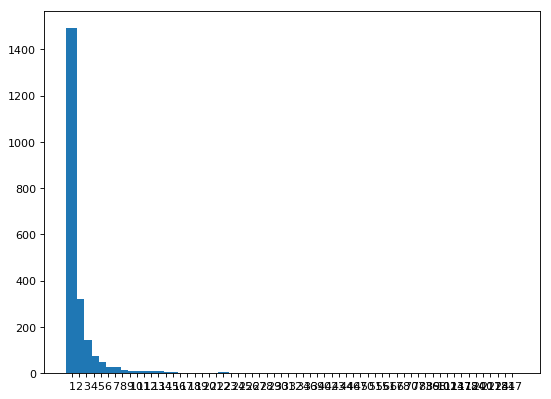

In [470]:
sorted_count = two_hundred_trees_freq.most_common()
_, counts = zip(*two_hundred_trees_freq.items())
counts = (list(counts))
counts.sort()

labels, values = zip(*Counter(counts).items())
indexes = np.arange(len(labels))


plt.figure(num=3, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
plt.bar(indexes, values, 1.5)
plt.xticks(indexes, labels)
plt.show()

### Part 2.3

In [641]:
def simplify_functional_tag(tag):
    if '-' in tag:
        tag = tag.split('-')[0]
    # -NONE- tag
    if "" == tag:
        return " "
    return tag

def get_tag_clean(tree):
    if isinstance(tree, Tree):
        simplified_tag = simplify_functional_tag(tree.label())
        return simplified_tag

def build_simplified_tree(tree):
    if isinstance(tree, Tree):
        root_tag = get_tag_clean(tree)
        if(" " == root_tag):
            return " "
        else:
            simplified_child_nodes = [build_simplified_tree(child) for child in tree]
            # remove all NONE children
            simplified_children = [child for child in  simplified_child_nodes if child != " "]
            if(len(simplified_children) >= 1):
                return(Tree(root_tag, simplified_children))
            else:
                # This means the only child is NONE so we can remove it from it's parent as well
                return " "
    else:
        return tree

In [571]:
def get_tag_or_value(tree):
    if isinstance(tree, Tree):
        return Nonterminal(tree.label())
    else:
        tree
        
def tree_to_production(tree):
    return Production(get_tag_or_value(tree),[get_tag_or_value(child) for child in tree])

def tree_to_productions(tree):
    yield tree_to_production(tree)
    for child in tree:
        if isinstance(child, Tree):
            for prod in tree_to_productions(child):
                if prod:
                    yield prod

In [638]:
def pcfg_cnf_learn(treebank, n):
    trees = treebank.parsed_sents()[:n]
    trees_productions = []
    for tree in trees:
        new_tree = build_simplified_tree(tree)
        chomsky_normal_form(tree, factor='right', horzMarkov=1, vertMarkov=1, childChar='|', parentChar='^')
        chomsky_normal_form(new_tree, factor='right', horzMarkov=1, vertMarkov=1, childChar='|', parentChar='^')
        productions = tree_to_productions(new_tree)
        trees_productions += [prod for prod in productions]
    pcfg_induced = induce_pcfg(Nonterminal('S'), trees_productions)
    return pcfg_induced

In [640]:
treebank = LazyCorpusLoader('treebank/combined', BracketParseCorpusReader, r'wsj_.*\.mrg')
pcfg_cnf = two_hundred_trees_pcfg = pcfg_cnf_learn(treebank, 200)